In [635]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [636]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# Titanic dataset... Let's find out who survived ! <a class="tocSkip">
    
### Notebook's Table of content : <a class="tocSkip">

1. Quick Data exploration...
    * Let's get more info to see how much data is missing...
    * Let's take a look at the numerical attributes:


2. Build your processing Pipeline
    * Clean Missing values 
    * Categorical values... Create your dummies !


3. Let's build our models now
    * Try some models
    * Evaluate
    

4. Iterate !
    * Go back to step 1
    * Try to add new features... # FeaturesEngineering
    * Fine tune
    * Evaluate
    
> *The goal is to predict whether or not a passenger survived based on attributes such as their age, sex, passenger class and so on.*

# Load the Data

In [637]:
import pandas as pd
import os

TITANIC_PATH = os.path.join("data", "titanic")

def load_titanic_data(filename: str, titanic_path: str = TITANIC_PATH) -> pd.DataFrame:
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

# First, let's make a quick data exploration ...


Let's take a peek some sample rows of the training set:

In [613]:
train_data.sample(10)

PassengerId  Survived  Pclass  \
709          710         1       3   
439          440         0       2   
840          841         0       3   
720          721         1       2   
39            40         1       3   
290          291         1       1   
300          301         1       3   
333          334         0       3   
208          209         1       3   
136          137         1       1   

                                                  Name     Sex   Age  SibSp  \
709  Moubarek, Master. Halim Gonios ("William George")    male   NaN      1   
439             Kvillner, Mr. Johan Henrik Johannesson    male  31.0      0   
840                        Alhomaki, Mr. Ilmari Rudolf    male  20.0      0   
720                  Harper, Miss. Annie Jessie "Nina"  female   6.0      0   
39                         Nicola-Yarred, Miss. Jamila  female  14.0      1   
290                       Barber, Miss. Ellen "Nellie"  female  26.0      0   
300           Kelly, Miss. Anna Katherine "Annie Kate"  female   NaN      0   
333                    Vander Planke, Mr. Leo Edmondus    male  16.0      2   
208                          Carr, Miss. Helen "Ellen"  female  16.0      0   
136                       Newsom, Miss. Helen Monypeny  female  19.0      0   

     Parch            Ticket     Fare Cabin Embarked  
709      1              2661  15.2458   NaN        C  
439      0        C.A. 18723  10.5000   NaN        S  
840      0  SOTON/O2 3101287   7.9250   NaN        S  
720      1            248727  33.0000   NaN        S  
39       0              2651  11.2417   NaN        C  
290      0             19877  78.8500   NaN        S  
300      0              9234   7.7500   NaN        Q  
333      0            345764  18.0000   NaN        S  
208      0            367231   7.7500   NaN        Q  
136      2             11752  26.2833   D47        S

The attributes have the following meaning:
* **Survived**: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
* **Pclass**: passenger class.
* **Name**, **Sex**, **Age**: self-explanatory
* **SibSp**: how many siblings & spouses of the passenger aboard the Titanic.
* **Parch**: how many children & parents of the passenger aboard the Titanic.
* **Ticket**: ticket id
* **Fare**: price paid (in pounds)
* **Cabin**: passenger's cabin number
* **Embarked**: where the passenger embarked the Titanic

## Let's get more info to see how much data is missing...


In [614]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [615]:
total = train_data.isnull().sum().sort_values(ascending=False)
percent_1 = train_data.isnull().sum()/train_data.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

Total     %
Cabin       687  77.1
Age         177  19.9
Embarked      2   0.2
Fare          0   0.0
Ticket        0   0.0

Okay, the **Age**, **Cabin** and **Embarked** attributes are sometimes null (less than 891 non-null).

> Especially the **Cabin** (77% are null). We will ignore the **Cabin** for now and focus on the rest. 

> The **Age** attribute has about 19% null values, so we will need to decide what to do with them. Replacing null values with the median age seems reasonable.

The **Name** and **Ticket** attributes may have some value, but they will be a bit tricky to convert into useful numbers that a model can consume. So for now, we will ignore them.

## Let's take a look at the numerical attributes:


In [616]:
train_data.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

* Only 38% **Survived** ==> That's close enough to 50%, so **ACCURACY** will be a reasonable metric to evaluate our model.


* The mean **Fare** was £32.20, which does not seem so expensive


* The mean **Age** was less than 30 years old.

## Let's take a look at the categorical attributes:

### Analyse Age and Sex

/Users/loic.caminale/venvs/cours_esme/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
/Users/loic.caminale/venvs/cours_esme/lib/python3.7/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/Users/loic.caminale/venvs/cours_esme/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


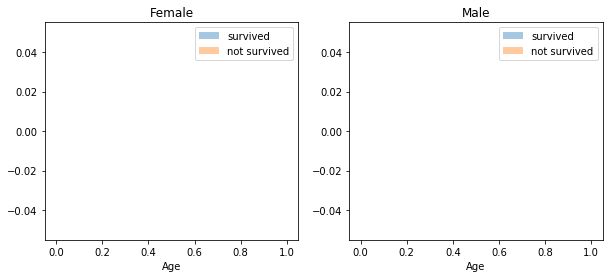

In [668]:
# To plot pretty figures
# data visualization
import seaborn as sns
import matplotlib.pyplot as plt

survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
women = train_data[train_data['Sex']=='female']
men = train_data[train_data['Sex']=='male']
ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False)
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[0], kde =False)
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False)
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False)
ax.legend()
_ = ax.set_title('Male')

## how many men and women have survived ?

In [618]:
surviving_men = str(len(men[men['Survived']==1]))
surviving_women = str(len(women[women['Survived']==1]))
print(surviving_men + " men surviving and " + surviving_women + " women surviving")

109 men surviving and 233 women surviving


### Analyse passenger class

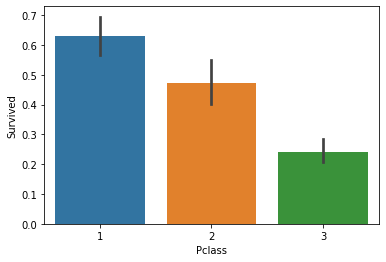

In [619]:
sns.barplot(x='Pclass', y='Survived', data=train_data)

In [620]:

nbr_survivor_into_class1 = train_data[(train_data["Pclass"]==1) & (train_data["Survived"]==1)].shape[0]
nbr_passenger_class1 = train_data[train_data["Pclass"]==1].shape[0]
nbr_survivor_into_class2 = train_data[(train_data["Pclass"]==2) & (train_data["Survived"]==1)].shape[0]
nbr_passenger_class2 = train_data[train_data["Pclass"]==2].shape[0]
nbr_survivor_into_class3 = train_data[(train_data["Pclass"]==3) & (train_data["Survived"]==1)].shape[0]
nbr_passenger_class3 = train_data[train_data["Pclass"]==3].shape[0]

In [621]:
print("* nbr survivor class 1: "+ str(round(nbr_survivor_into_class1/nbr_passenger_class1,2)) + "% " +str(nbr_survivor_into_class1) + " on " + str(nbr_passenger_class1)+"\n")
print("* nbr survivor class 2: "+ str(round(nbr_survivor_into_class2/nbr_passenger_class2,2)) + "% " + str(nbr_survivor_into_class2) + " on " + str(nbr_passenger_class2) + "\n")
print("* nbr survivor class 3: "+ str(round(nbr_survivor_into_class3/nbr_passenger_class3,2)) + "% " + str(nbr_survivor_into_class3) + " on " + str(nbr_passenger_class3) + "\n")

* nbr survivor class 1: 0.63% 136 on 216

* nbr survivor class 2: 0.47% 87 on 184

* nbr survivor class 3: 0.24% 119 on 491



#### Observations:
* Pclass is contributing to a persons chance of survival

# Age according to passenger class

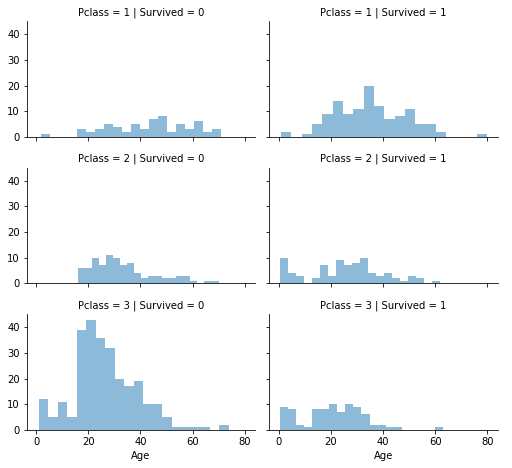

In [622]:
grid = sns.FacetGrid(train_data, col='Survived', row='Pclass',height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

* First class : best age for survive is between 20 to 50
* Second class : best age for survive is between 0 to 10 and 25 to 30
* Third class : best age for survive is between 15 to 35

# Let's build our ... preprocessing pipeline !

## Clean Missing values

### AGE

In [638]:
data = [train_data, test_data]
for dataset in data:
    mean = train_data["Age"].mean()
    std = test_data["Age"].std()
    nbr_null_values = dataset["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = nbr_null_values)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = train_data["Age"].astype(int)
train_data["Age"].isnull().sum()
dataset["Age"].isnull().sum()

0

### Embarked

In [639]:
train_data['Embarked'].describe()


count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

- Since the Embarked feature has only 2 missing values, we will just fill these with the most common one.

In [640]:
common_value = train_data['Embarked'].describe().top
data = [train_data, test_data]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)

In [641]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null int64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       891 non-null object
dtypes: float64(1), int64(6), object(5)
memory usage: 83.7+ KB


## Fare

In [642]:
data = [train_data, test_data]

for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)

# Converting categorical Features

## Converting Sex into numeric values 

In [643]:
genders = {"male": 0, "female": 1}
data = [train_data, test_data]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

## Convert Embarked values to numeric values

In [644]:
train_data["Embarked"].unique()

array(['S', 'C', 'Q'], dtype=object)

In [645]:
ports = {"S": 0, "C": 1, "Q": 2}
data = [train_data, test_data]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

## Extract the title from the name (Mr, Miss...)

In [646]:
 train_data.Name.unique()

array(['Braund, Mr. Owen Harris',
       'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
       'Heikkinen, Miss. Laina',
       'Futrelle, Mrs. Jacques Heath (Lily May Peel)',
       'Allen, Mr. William Henry', 'Moran, Mr. James',
       'McCarthy, Mr. Timothy J', 'Palsson, Master. Gosta Leonard',
       'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)',
       'Nasser, Mrs. Nicholas (Adele Achem)',
       'Sandstrom, Miss. Marguerite Rut', 'Bonnell, Miss. Elizabeth',
       'Saundercock, Mr. William Henry', 'Andersson, Mr. Anders Johan',
       'Vestrom, Miss. Hulda Amanda Adolfina',
       'Hewlett, Mrs. (Mary D Kingcome) ', 'Rice, Master. Eugene',
       'Williams, Mr. Charles Eugene',
       'Vander Planke, Mrs. Julius (Emelia Maria Vandemoortele)',
       'Masselmani, Mrs. Fatima', 'Fynney, Mr. Joseph J',
       'Beesley, Mr. Lawrence', 'McGowan, Miss. Anna "Annie"',
       'Sloper, Mr. William Thompson', 'Palsson, Miss. Torborg Danira',
       'Asplund, Mrs. Carl Oscar 

In [647]:
data = [train_data, test_data]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    # extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    print(dataset['Title'].unique())
    # replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # convert titles into numbers
    dataset['Title'] = dataset['Title'].map(titles)
    # filling NaN with 0, to get safe
    dataset['Title'] = dataset['Title'].fillna(0)
train_data = train_data.drop(['Name'], axis=1)
test_data = test_data.drop(['Name'], axis=1)

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'Countess' 'Jonkheer']
['Mr' 'Mrs' 'Miss' 'Master' 'Ms' 'Col' 'Rev' 'Dr' 'Dona']


# Creating Categories

## Categorize the ‘age’ feature

In [648]:
data = [train_data, test_data]
nbr_categories = 7
for dataset in data:
    dataset['Age'] = pd.qcut(dataset["Age"], nbr_categories, labels=False)

In [650]:
data[0]["Age"].describe()

count    891.000000
mean       2.911336
std        2.020678
min        0.000000
25%        1.000000
50%        3.000000
75%        5.000000
max        6.000000
Name: Age, dtype: float64

Be careful that the data is distributed fairly well in the categories so as not to have, for example, 80% of the data in category 1

In [651]:
train_data['Age'].value_counts()

1    150
4    137
0    135
6    124
3    117
5    115
2    113
Name: Age, dtype: int64

## Categorize the ‘fare’ feature

In [652]:
data = [train_data, test_data]
nbr_categories = 6
for dataset in data:
    dataset["Fare"] = pd.qcut(dataset["Fare"], nbr_categories, labels=False)

## Drop columns, not revelevant data

### Drop PassengerID column because not relevant ! and cabin because a lot of missing values

In [653]:
train_data = train_data.drop(['PassengerId'], axis=1)
train_data = train_data.drop(['Cabin'], axis=1)
test_data = test_data.drop(['PassengerId'], axis=1)
test_data = test_data.drop(['Cabin'], axis=1)

### Drop Ticket because of 681 differents values : can't categories them easily

In [654]:
train_data['Ticket'].describe()

count      891
unique     681
top       1601
freq         7
Name: Ticket, dtype: object

In [655]:
train_data = train_data.drop(['Ticket'], axis=1)
test_data = test_data.drop(['Ticket'], axis=1)

# Building Machine Learning Models

## Inputs for models

In [656]:
Y_train = train_data["Survived"]
X_train = train_data.drop("Survived", axis=1)
X_test  = test_data


## Model Random Forest

In [657]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)

Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)

## K Nearest Neighbor

In [658]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)  
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)

In [659]:
results = pd.DataFrame({
    'Model': ['KNN', 
              'Random Forest'],
    'Score': [acc_knn, 
              acc_random_forest]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df.head(9)


Model
Score               
91.13  Random Forest
87.65            KNN

# Feature Importance on Random Forest

In [661]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(15)

importance
feature             
Title          0.215
Sex            0.182
Age            0.167
Fare           0.133
Pclass         0.119
SibSp          0.076
Parch          0.055
Embarked       0.052

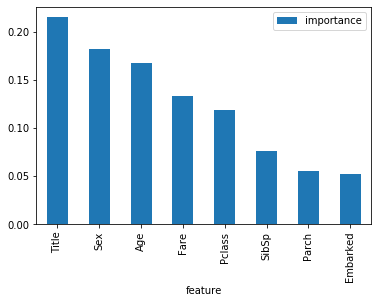

In [662]:
importances.plot.bar()

# Try to add new features... # FeaturesEngineering

## Combine SibSp and Parch: show if someone is not alone.

In [669]:
data = [train_data, test_data]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype(int)
train_data['not_alone'].value_counts()

1    537
0    354
Name: not_alone, dtype: int64

/Users/loic.caminale/venvs/cours_esme/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


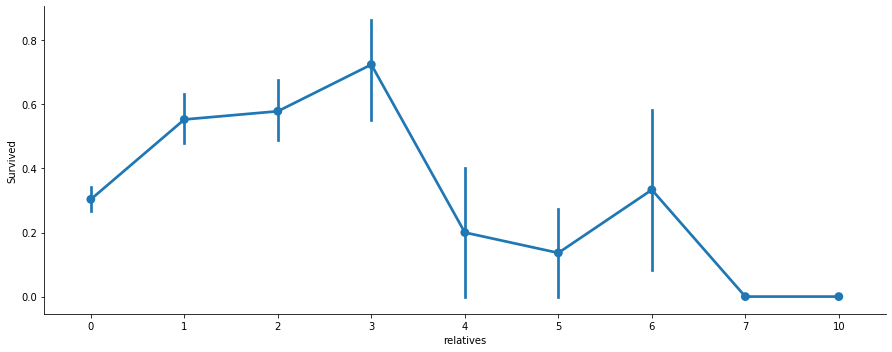

In [670]:
axes = sns.factorplot('relatives','Survived', 
                      data=train_data, aspect = 2.5, )

Best probability to survive is **between 0 and 3 relatives**

## Age and Class

In [671]:
for dataset in data:
    dataset['Age_Class']= dataset['Age']* dataset['Pclass']

## Fare per Person

In [672]:
for dataset in data:
    dataset['Fare_Per_Person'] = dataset['Fare']/(dataset['relatives']+1)
    dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)
# Let's take a last look at the training set, before we start training the models.
train_data.head(10)

Survived  Pclass  Sex  Age  SibSp  Parch  Fare  Embarked  Title  relatives  \
0         0       3    0    1      1      0     0         0      1          1   
1         1       1    1    5      1      0     5         1      3          1   
2         1       3    1    2      0      0     0         0      2          0   
3         1       1    1    4      1      0     5         0      3          1   
4         0       3    0    4      0      0     1         0      1          0   
5         0       3    0    1      0      0     1         2      1          0   
6         0       1    0    6      0      0     4         0      1          0   
7         0       3    0    0      3      1     3         0      4          4   
8         1       3    1    3      0      2     2         0      3          2   
9         1       2    1    0      1      0     4         1      3          1   

   not_alone  Age_Class  Fare_Per_Person  
0          0          3                0  
1          0          5                2  
2          1          6                0  
3          0          4                2  
4          1         12                1  
5          1          3                1  
6          1          6                4  
7          0          0                0  
8          0          9                0  
9          0          0                2

# Test Random Forest with new features

## Inputs for models

In [673]:
Y_train = train_data["Survived"]
X_train = train_data.drop("Survived", axis=1)
X_test  = test_data

## Model Random Forest

In [675]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)

Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

91.13

## Feature importances

In [678]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(15)

importance
feature                    
Title                 0.221
Sex                   0.173
Age_Class             0.098
Fare                  0.089
Pclass                0.087
Age                   0.083
relatives             0.059
Fare_Per_Person       0.058
Embarked              0.056
SibSp                 0.035
Parch                 0.028
not_alone             0.014

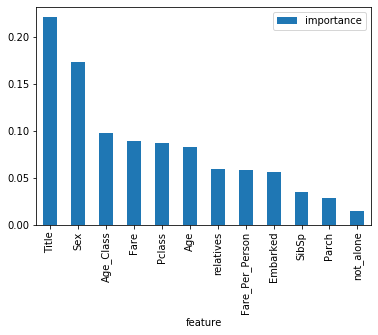

In [679]:
importances.plot.bar()

In [680]:
train_data  = train_data.drop("not_alone", axis=1)
test_data  = test_data.drop("not_alone", axis=1)

train_data  = train_data.drop("Parch", axis=1)
test_data  = test_data.drop("Parch", axis=1)

## Test Random Forest with dropped features

In [681]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)

Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

91.13

# Out-Of-Bag error a way to evaluate a random-forest classifier

In [682]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100, oob_score = True)
random_forest.fit(X_train, Y_train)
Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)

acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)

In [683]:
print("oob score:", round(random_forest.oob_score_, 4)*100, "%")


oob score: 79.46 %


Not so cool !!!

# Fine tune, Hyperparameter Tuning


Grid search is the process of performing hyper parameter tuning in order to determine the optimal values for a given model. This is significant as the performance of the entire model is based on the hyper parameter values specified.

param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10, 25, 50, 70], "min_samples_split" : [2, 4, 10, 12, 16, 18, 25, 35], "n_estimators": [100, 400, 700, 1000, 1500]}
from sklearn.model_selection import GridSearchCV
rf = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1, n_jobs=-1)
clf = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1)
clf.fit(X_train, Y_train)
clf.estimator

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=1, verbose=0,
                       warm_start=False)

## Ok now we have new parameters, go to test it:

In [684]:
random_forest = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=1, verbose=0,
                       warm_start=False)

random_forest.fit(X_train, Y_train)
Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)

print("oob score:", round(random_forest.oob_score_, 4)*100, "%")

oob score: 82.6 %


Nice job !!! 80.25 to 82.27%

## If we go a little more into the details with **confusion matrix**

Confusion matrix measures the quality of a classification system. 

In [603]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
predictions = cross_val_predict(random_forest, X_train, Y_train, cv=3)
repartitions = confusion_matrix(Y_train, predictions)
repartitions

array([[489,  60],
       [ 96, 246]])

In [604]:
positifs = repartitions[0][1]/repartitions[0][0]
negatifs = repartitions[1][0]/repartitions[1][1]
print(positifs, negatifs)

0.12269938650306748 0.3902439024390244


* First row The first row is about the **not-survived-predictions: 489 passengers** were **correctly classified** as not survived (called true negatives) **60 where wrongly classified** as not survived (false positives).
* The second row is about the **survived-predictions: 96 passengers** where wrongly classified as survived (false negatives) and **246 where correctly classified** as survived (true positives).

## Precision and Recall

*  precision (also called positive predictive value) is the fraction of **relevant instances** among the **retrieved instances**
* recall (also known as sensitivity) is the fraction of the **total amount of relevant instances** that were **actually retrieved**. 

Suppose a computer program for recognizing dogs in photographs **identifies 8 dogs** in a picture containing **12 dogs** and some cats. 
Of the 8 identified as dogs:
* **5** actually are dogs (true positives)
* **3** are cats (false positives). 

The program's precision is **5/8** while its recall is **5/12**

In [498]:
from sklearn.metrics import precision_score, recall_score

print("Precision:", precision_score(Y_train, predictions))
print("Recall:",recall_score(Y_train, predictions))

Precision: 0.803921568627451
Recall: 0.7192982456140351


# F-Score

Combine recall and precision

<img src="static/F-score.png">

In [499]:
from sklearn.metrics import f1_score
f1_score(Y_train, predictions)

0.7592592592592592

**Increasing precision**, sometimes results in an **decreasing recall** and vice versa (depending on the threshold). This is called the precision/recall tradeoff.

## Precision Recall Curve

For each person the Random Forest algorithm has to classify, it computes a probability based on a function and it classifies a person:
* Survived when **score > threshold**
* not survived when **score < threshold**

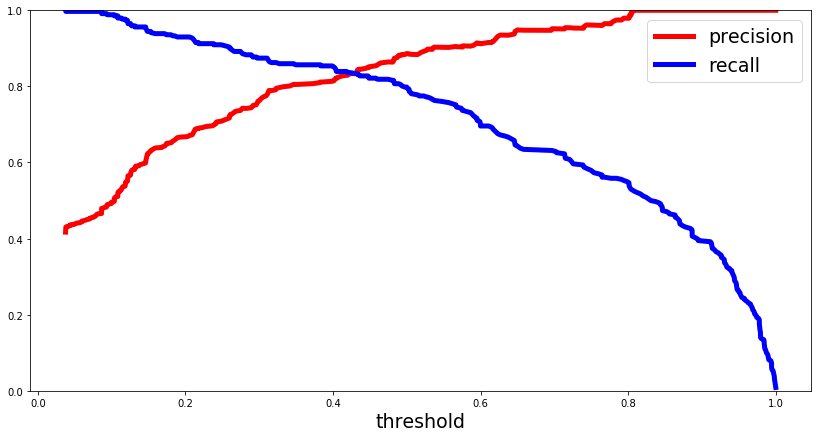

In [500]:
from sklearn.metrics import precision_recall_curve

# getting the probabilities of our predictions
y_scores = random_forest.predict_proba(X_train)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(Y_train, y_scores)
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

If you want for example a precision of 80%, you can easily look at the plots and see that you would need a threshold of around 0.4.

## Another way is to plot the precision and recall against each other:

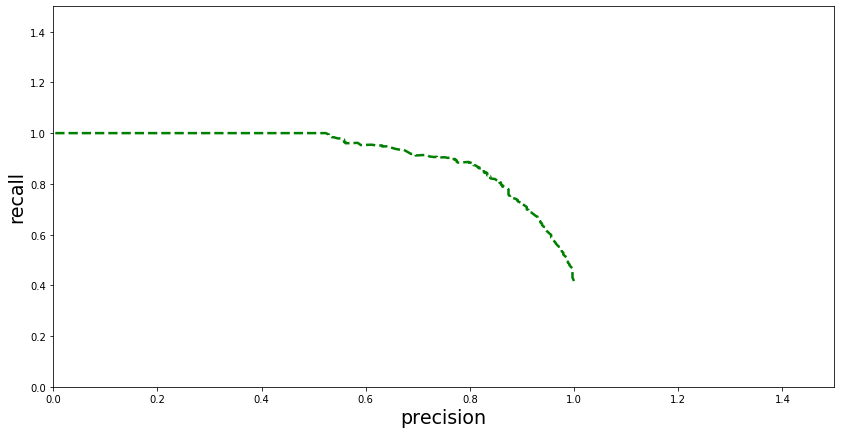

In [503]:
def plot_precision_vs_recall(precision, recall):
    plt.plot(recall, precision, "g--", linewidth=2.5)
    plt.ylabel("recall", fontsize=19)
    plt.xlabel("precision", fontsize=19)
    plt.axis([0, 1.5, 0, 1.5])

plt.figure(figsize=(14, 7))
plot_precision_vs_recall(precision, recall)
plt.show()

## ROC AUC Curve, This curve plots the true positive rate against the false positive rate

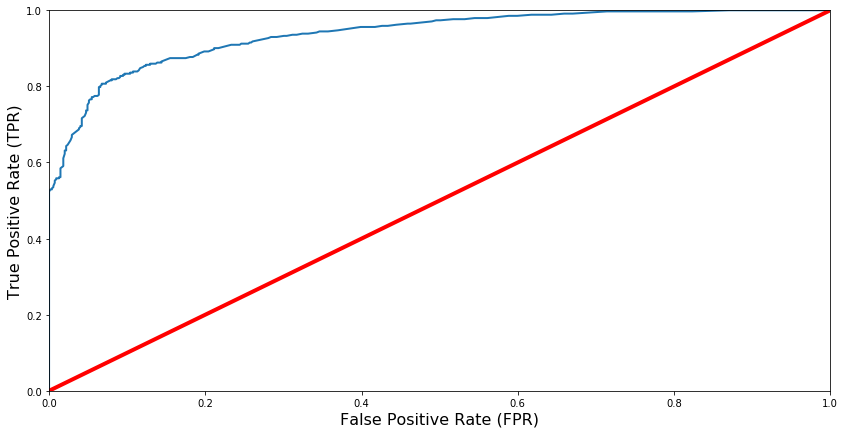

In [504]:
from sklearn.metrics import roc_curve
# compute true positive rate and false positive rate
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_train, y_scores)
# plotting them against each other
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize=(14, 7))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

The **red line** in the middel represents a **purely random classifier** (e.g a coin flip) and therefore your classifier **should be as far away from it** as possible. Our Random Forest model seems to do a good job.

## ROC AUC SCORE : calculate the area under the curve

A classifiers that is **100% correc**t, would have a **ROC AUC Score of 1** 
A completely **random classiffier** would have a score of **0.5.**

In [506]:
from sklearn.metrics import roc_auc_score
r_a_score = roc_auc_score(Y_train, y_scores)
print("ROC-AUC-Score:", r_a_score)

ROC-AUC-Score: 0.9370759168717179
